## Sentiment Classification Model
---

This notebook utilizes a sentiment analysis dataset from [kaggle](https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset)

#### Context

Every text can have a different sentiment, whether it be a positive, negative, or neutral sentiment. Traditionally, us humans try to gather what sentiment a text has through various patterns within the text, such as meaning of specific key words and what context they are used in. In this notebook, I wanted to explore how I could create a machine learning model that could categorize different texts into their respective sentiments. 


#### Importing libraries and data

Here we will be importing all the necessary libraries along with importing the dataset and converting it into usable pandas dataframe

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn

In [3]:
encoding = "unicode_escape"

train_df = pd.read_csv("./data/SentimentAnalysis/train.csv", encoding=encoding)
test_df = pd.read_csv("./data/SentimentAnalysis/test.csv", encoding=encoding)

In [4]:
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


Looking at the dataset, it seems we have 9 different categories:

- `textID`
- `text`
- `selected_text`
- `sentiment`
- `Time of Tweet`
- `Age of User`
- `Country`
- `Population-2020`
- `Land Area (Km^2)`
- `Density`

Realistically, we only really need to account for two features which would be `text` and `sentiment`. `selected_text` is helpful in the sense that it garners the main text, however we want our model to be able to find those patterns that allow for these specified words to categorize a text into a specific sentiment. Everything else is just external information that is not really related to the text itself. We only care about looking for the patterns within the text.

Let's clean up this dataset a bit.


### Cleaning the Data

First, lets drop all the rows that have null values

In [5]:
train_df = train_df.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27480 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27480 non-null  object 
 4   Time of Tweet     27480 non-null  object 
 5   Age of User       27480 non-null  object 
 6   Country           27480 non-null  object 
 7   Population -2020  27480 non-null  int64  
 8   Land Area (Km²)   27480 non-null  float64
 9   Density (P/Km²)   27480 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.3+ MB


In [6]:
train_df[["sentiment", "text"]]

,sentiment,text
0,neutral,"I`d have responded, if I were going"
1,negative,Sooo SAD I will miss you here in San Diego!!!
2,negative,my boss is bullying me...
3,negative,what interview! leave me alone
4,negative,"Sons of ****, why couldn`t they put them on t..."
...,...,...
27476,negative,wish we could come see u on Denver husband l...
27477,negative,I`ve wondered about rake to. The client has ...
27478,positive,Yay good for both of you. Enjoy the break - y...
27479,positive,But it was worth it ****.


We can now also remove text that references users such as @username since they will not contribute to overall sentiment analysis

In [7]:
train_df["text"] = train_df["text"].str.replace(r'@[\w_]+', '')

We also want to make sure that there is a relative equal number of each sentiment, so our model doesn't overfit to a specific sentiment

In [8]:
train_df["sentiment"].value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

With there being an unequal amount, we can take the minimum number of sentiments (which is the negative in this case) and reduce the number of rows randomly from the other sentiments so each sentiment has an equal amount

In [9]:
min_count = min(train_df["sentiment"].value_counts())
min_count

7781

In [10]:
balanced_train_df = pd.DataFrame(columns=["text", "sentiment"])

In [11]:
for sentiment in train_df["sentiment"].unique():
    sentiment_subset = train_df[train_df["sentiment"] == sentiment]
    balanced_subset = sentiment_subset.sample(n=min_count, random_state=1)
    balanced_train_df = pd.concat([balanced_train_df, balanced_subset])

In [13]:
balanced_train_df = balanced_train_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [12]:
balanced_train_df["sentiment"].value_counts()

sentiment
neutral     7781
negative    7781
positive    7781
Name: count, dtype: int64

Now let's take a look at what our dataset looks like

In [13]:
balanced_train_df

,text,sentiment,textID,selected_text,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
12458,I don`t know what this is all about but I`m g...,neutral,548556fb49,I don`t know what this is all about but I`m g...,night,31-45,Barbados,287375.0,430.0,668.0
11193,Hah! Sparkly ones at that.,neutral,b027a5473f,Hah! Sparkly ones at that.,morning,46-60,Democratic Republic of the Congo,89561403.0,2267050.0,40.0
24713,_agwl Talking to whom? This `Shah Rukh Khan` i...,neutral,021f556f61,_agwl Talking to whom? This `Shah Rukh Khan` i...,night,70-100,Kiribati,119449.0,810.0,147.0
23663,why r y depressed? i mite b moving earlyer t...,neutral,75929f0ab9,why r y depressed? i mite b moving earlyer th...,night,70-100,Portugal,10196709.0,91590.0,111.0
7371,I hate sitting at the doctors office! They tol...,neutral,4da2acbf81,I hate sitting at the doctors office! They tol...,morning,46-60,Micronesia,115023.0,700.0,164.0
...,...,...,...,...,...,...,...,...,...,...
8827,*hugs* I`m so sorry.. anything I can do?,positive,b78beab7b8,I`m so sorry.,noon,21-30,Iceland,341243.0,100250.0,3.0
23342,Happy Baby Mommas Day!! to all the>> MOMMAS<<...,positive,9b59214560,Happy,night,31-45,Barbados,287375.0,430.0,668.0
15452,I`m only telling the truth..... You know you...,positive,62d3507f98,ow you have skills,night,31-45,Burkina Faso,20903273.0,273600.0,76.0
6686,Good morning MiaMiaDC My weekend was great a...,positive,1c2e845644,a wonderfu,night,31-45,Bahamas,393244.0,10010.0,39.0


### Data Preprocessing

Now let's start preprocessing our data so we can use it within our model. We'll first Tokenize our data using tensorflow's Tokenizer utility

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

We'll set the max number of words to 5000 and create our Tokenizer

In [15]:
MAX_WORDS = 5000

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")

In [16]:
balanced_train_df["text_copy"] = balanced_train_df["text"]

In [17]:
tokenizer.fit_on_texts(balanced_train_df["text"])

We'll then save the word_index so we can use it to translate from Numerical Values to text

In [20]:
word_index = tokenizer.word_index

In [45]:
balanced_train_df["sequenced_text"] = tokenizer.texts_to_sequences(balanced_train_df["text"])
balanced_train_df["X_train"] = balanced_train_df["sequenced_text"].tolist()

Now let's see what our dataset looks like

In [55]:
balanced_train_df.head()

,text,sentiment,textID,selected_text,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),text_copy,sequenced_text,X_train
12458,I don`t know what this is all about but I`m g...,neutral,548556fb49,I don`t know what this is all about but I`m g...,night,31-45,Barbados,287375.0,430.0,668.0,I don`t know what this is all about but I`m g...,"[2, 64, 14, 60, 53, 32, 10, 30, 67, 21, 2, 22,...","[2, 64, 14, 60, 53, 32, 10, 30, 67, 21, 2, 22,..."
11193,Hah! Sparkly ones at that.,neutral,b027a5473f,Hah! Sparkly ones at that.,morning,46-60,Democratic Republic of the Congo,89561403.0,2267050.0,40.0,Hah! Sparkly ones at that.,"[1805, 1, 543, 28, 16]","[1805, 1, 543, 28, 16]"
24713,_agwl Talking to whom? This `Shah Rukh Khan` i...,neutral,021f556f61,_agwl Talking to whom? This `Shah Rukh Khan` i...,night,70-100,Kiribati,119449.0,810.0,147.0,_agwl Talking to whom? This `Shah Rukh Khan` i...,"[1, 507, 3, 3133, 32, 1, 1, 1, 10, 96, 1, 93, ...","[1, 507, 3, 3133, 32, 1, 1, 1, 10, 96, 1, 93, ..."
23663,why r y depressed? i mite b moving earlyer t...,neutral,75929f0ab9,why r y depressed? i mite b moving earlyer th...,night,70-100,Portugal,10196709.0,91590.0,111.0,why r y depressed? i mite b moving earlyer t...,"[117, 371, 585, 1306, 2, 3523, 327, 694, 1, 19...","[117, 371, 585, 1306, 2, 3523, 327, 694, 1, 19..."
7371,I hate sitting at the doctors office! They tol...,neutral,4da2acbf81,I hate sitting at the doctors office! They tol...,morning,46-60,Micronesia,115023.0,700.0,164.0,I hate sitting at the doctors office! They tol...,"[2, 150, 475, 28, 4, 2354, 438, 73, 535, 17, 1...","[2, 150, 475, 28, 4, 2354, 438, 73, 535, 17, 1..."


Let's pad our sequences so each text is an array of equal length (in this case a length of 5000)

In [56]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

After padding, each array representing the text is now of equal length.

In [66]:
X_train = pad_sequences(balanced_train_df["X_train"], maxlen=5000)
X_train

array([[   0,    0,    0, ...,  608,    3,  133],
       [   0,    0,    0, ...,  543,   28,   16],
       [   0,    0,    0, ...,   13,    4,  257],
       ...,
       [   0,    0,    0, ...,    8,   20, 2339],
       [   0,    0,    0, ...,    5,  542,   24],
       [   0,    0,    0, ...,   54,    6, 2218]], dtype=int32)

Now let's remap our sentiments so that they're numerical values instead of negative, neutral and positive

In [69]:
sentiment_mapping = {"negative": 0, "neutral": 1, "positive": 2}
y_train = balanced_train_df["sentiment"].replace(sentiment_mapping)


In [70]:
y_train

12458    1
11193    1
24713    1
23663    1
7371     1
        ..
8827     2
23342    2
15452    2
6686     2
6874     2
Name: sentiment, Length: 23343, dtype: int64

Furthremore, we want to one hot encode the numbers as well, so we'll use sklearn's to_categorical utility for this.

In [62]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, shuffle=True)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [73]:
y_train

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

### Creating our model

For our model, we will be using a [model based on this academic paper](https://arxiv.org/abs/2307.06540) that was also trained on a sentiment analysis dataset.

In [89]:
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM, GRU, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [90]:
# Define the model
model = tf.keras.Sequential()

# 1) Embedding Layer
model.add(Embedding(input_dim=5000, output_dim=50, input_length=5000))

# 2) Dropout Layer
model.add(Dropout(0.2))

# 3) Convolutional Layer (Conv1D)
model.add(Conv1D(filters=250, kernel_size=3, activation='relu', strides=1))

# 4) GlobalMaxPooling1D Layer
model.add(GlobalMaxPooling1D())

# 5) Dense (Fully Connected) Layer
model.add(Dense(250, activation='relu'))

# 6) Dropout Layer
model.add(Dropout(0.2))

# 7) Output Layer
model.add(Dense(3, activation='softmax'))  # 3 output neurons for 3 sentiment categories

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 5000, 50)          250000    
                                                                 
 dropout_13 (Dropout)        (None, 5000, 50)          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 4998, 250)         37750     
                                                                 
 global_max_pooling1d_6 (Gl  (None, 250)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_10 (Dense)            (None, 250)               62750     
                                                                 
 dropout_14 (Dropout)        (None, 250)               0         
                                                      

### Training our model

Now let's see how our model does. We'll train it with a batch size of 256 and for 10 epochs

In [91]:
batchsize = 256
epochs =  10

# Fit model
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Epoch 1/10


2023-10-26 23:29:56.907888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 66s 1s/step - loss: 1.0448 - accuracy: 0.4522 - val_loss: 0.8431 - val_accuracy: 0.6169
Epoch 2/10
59/59 [==============================] - 55s 940ms/step - loss: 0.7289 - accuracy: 0.6854 - val_loss: 0.6920 - val_accuracy: 0.7087
Epoch 3/10
59/59 [==============================] - 51s 858ms/step - loss: 0.5956 - accuracy: 0.7564 - val_loss: 0.6859 - val_accuracy: 0.7167
Epoch 4/10
59/59 [==============================] - 50s 840ms/step - loss: 0.5168 - accuracy: 0.7956 - val_loss: 0.7134 - val_accuracy: 0.7167
Epoch 5/10
59/59 [==============================] - 48s 813ms/step - loss: 0.4481 - accuracy: 0.8283 - val_loss: 0.7762 - val_accuracy: 0.7055
Epoch 6/10
59/59 [==============================] - 47s 805ms/step - loss: 0.3921 - accuracy: 0.8539 - val_loss: 0.8486 - val_accuracy: 0.7052
Epoch 7/10
59/59 [==============================] - 46s 780ms/step - loss: 0.3420 - accuracy: 0.8734 - val_loss: 0.9399 - val_accuracy: 0.6937
Epoch 8/10
59

### Results

Let's plot our results

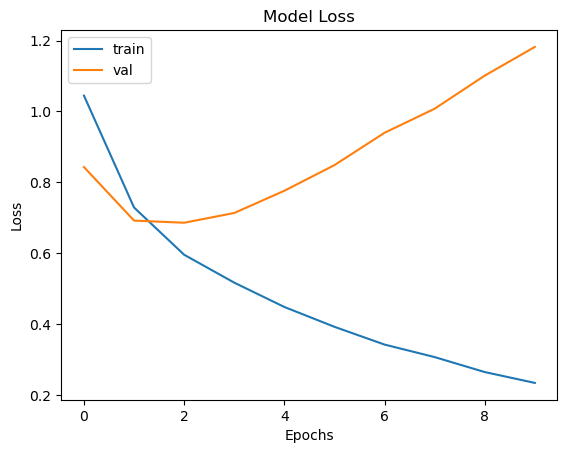

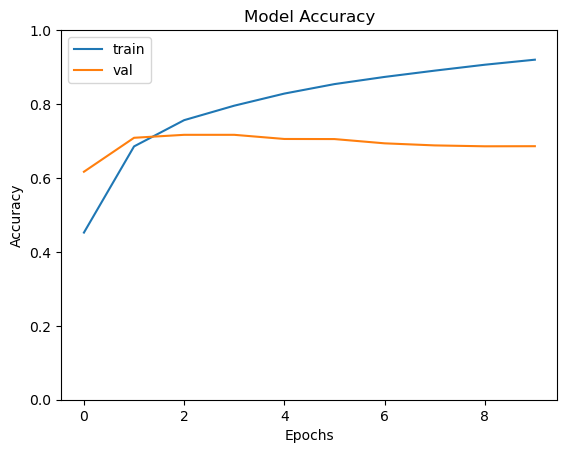

In [92]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.ylim([0,1])
plt.show()

We were able to attain an accuracy of 92% which is actually pretty good! Let's test our model out on generic text. I'm using encode and decode functions written during a previous machine learning class project.

In [99]:
import string, textwrap

def encode(review, word_dict, maxlen):
  encoded_review = []
  for raw_word in review.split(' '):
    word = raw_word.strip().strip(string.punctuation).lower()
    if word == '' or word == '\n':
      continue
    try:
      encoded_review.append(word_dict[word])
    except KeyError as e:
      # raise KeyError(f'{e} not in word dictionary, review not encoded.')
      continue
  return pad_sequences(np.array(encoded_review).reshape(1,-1), maxlen=maxlen)

def decode(encoded_review, inverse_word_dict):
  sentence = []
  for encoded_word in encoded_review:
    if encoded_word == 0:
      continue
    sentence.append(inverse_word_dict[encoded_word])
  w = textwrap.TextWrapper(width=120,break_long_words=False,replace_whitespace=False)
  return '\n'.join(w.wrap(' '.join(sentence)))

In [115]:
testScript = "I hate this model"
test = encode(testScript, word_index, 5000)
model.predict(test)

1/1 [==============================] - 0s 17ms/step


array([[9.9909711e-01, 9.0275181e-04, 1.7724659e-07]], dtype=float32)

It looks like it predicts it's a negative sentiment! Seems like it's working pretty well! Let's set it so that it's more readable

In [98]:
word_dict = word_index

In [100]:
inverse_word_dict = {value:key for key,value in word_dict.items()}

In [127]:
def testModel(script):
    test = encode(script, word_index, 5000)
    value= model.predict(test)
    value = np.round(value, 3)
    return value

In [131]:
print((testModel("I love you")))

1/1 [==============================] - 0s 14ms/step
[[0.    0.001 0.999]]


Now we can save our model and utilize it in different applications

In [132]:
model.save("trained_models/sentimentAnalysisModel.h5")

/Users/ethandomingo/Documents/CODING/tensorflow-test/env/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [133]:
import json


In [134]:
with open("word_dict.json", "w") as f:
    json.dump(word_index, f)